#### Содержание<a name="content"></a>:  
1. [Получение и предобработка данных](#getdata)
2. [Подготовка признаков](#preprocess)
3. [Обучение моделей](#modelsteach)  
- 3.1. [Несбалансированная классификация](#disbalanceclasses)  
    - 3.1.1. [Логистическая регрессия](#dislogisticregress)
    - 3.1.2. [Решающее дерево](#disdecisiontree)
    - 3.1.3. [Случайный лес](#disrandomforest)
- 3.2. [Балансирование классов](#balancingclasses)  
    - 3.2.1. [Логистическая регрессия](#ballogisticregress)
    - 3.2.2. [Решающее дерево](#baldecisiontree)
    - 3.2.3. [Случайный лес](#balrandomforest)
4. [Финальное тестирование](#finaltest)
5. [Выводы](#opinion)

---
## Выполнение проекта

### 1. Получение и предобработка данных<a name="getdata"></a>  
[к содержанию](#content)

Импортируем необходимые библиотеки и модули для работы.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

Получим данные, и ознакомимся с ними.

In [2]:
df = pd.read_csv(r'/datasets/Churn.csv')
display(df)

Проверим на наличие дубликатов.

In [3]:
df.duplicated().sum()

Проверим типы данных и пропуски в столбцах.

In [4]:
df.info()

Отсутствуют около 10% данных в столбце `Tenure`.

In [5]:
print(sorted(df.Tenure.unique()))

Если удалить строки с пропусками, потеря данных будет слишком большой. Поэтому заполним пропуски медианнным значением.

In [6]:
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())

Проверим баланс классов в целевом признаке.

In [7]:
df['Exited'].value_counts(normalize=True)

80:20 (4:1). "Нулей" в четыре раза больше, однако это не 99:1.  

Проверим категориальные значения - Географию и пол. Не слишком ли много дамми-признаков мы получим, если проведем прямое кодирование (оно будет уместно, т.к. большинство признаков количественные).

In [8]:
print(df['Geography'].value_counts(normalize=True)) 
print()
print(df['Gender'].value_counts(normalize=True))

Стран всего 3, полов 2. С учетом `drop_first`, дамми-ловушки можно не опасаться.

### 2. Подготовка признаков<a name="preprocess"></a>  
[к содержанию](#content)

Удалим столбцы с лишней информацией:  
- **`RowNumber`** - просто дублирует индексы  
- **`CustomerId`** и **`Surname`** - идентификаторы пользователя, никак не определяющие его поведение.

Преобразуем датафрейм в OHE.

In [9]:
df_teach = pd.get_dummies(df.drop(columns=['RowNumber', 'CustomerId', 'Surname']), drop_first=True)
df_teach

Сделаем список числовых столбцов, не являющихся флагами (0, 1), и проверим корреляцию их значений между собой.

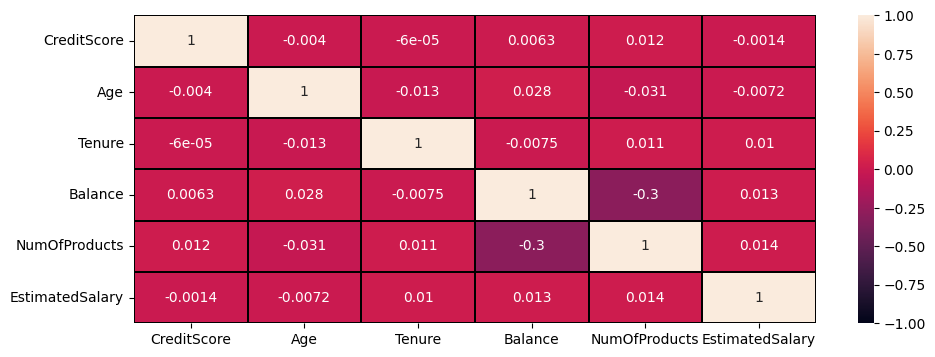

In [10]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

plt.figure(figsize=(11, 4))
sns.heatmap(data=df[numeric].corr(), annot=True, vmin=-1, vmax=1, linewidths=0.1, linecolor='black')
plt.show()

Выраженной корреляции нет, отлично.  

Создадаим таблицу признаков и целевую переменную. Разделим датафрейм на обучающую, валидационную и тестовую выборки. Проверим размерность.

In [11]:
target = df_teach['Exited']
features = df_teach.drop(columns=['Exited'])

features_train, features_valid_test, target_train, target_valid_test = train_test_split(features, 
                                                                                        target, 
                                                                                        test_size=0.4, 
                                                                                        random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test, 
                                                                            target_valid_test, 
                                                                            test_size=0.5, 
                                                                            random_state=12345)

print('features train', features_train.shape[0])
print('features valid', features_valid.shape[0])
print('features test', features_test.shape[0])

Разделение прошло корректно.  

Масштабируем количественные признаки, которые выделили ранее.

In [12]:
scaler = StandardScaler()

scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

### 3. Обучение моделей<a name="modelsteach"></a>  

Обучим разные ML-модели и посмотрим на результат.

#### 3.1. Несбалансированная классификация<a name="disbalanceclasses"></a>  

##### 3.1.1. Логистическая регрессия<a name="dislogisticregress"></a>  
[к содержанию](#content)

Обучим модель логистической регрессии, посчитаем метрики качества и построим график кривой `ROC`.

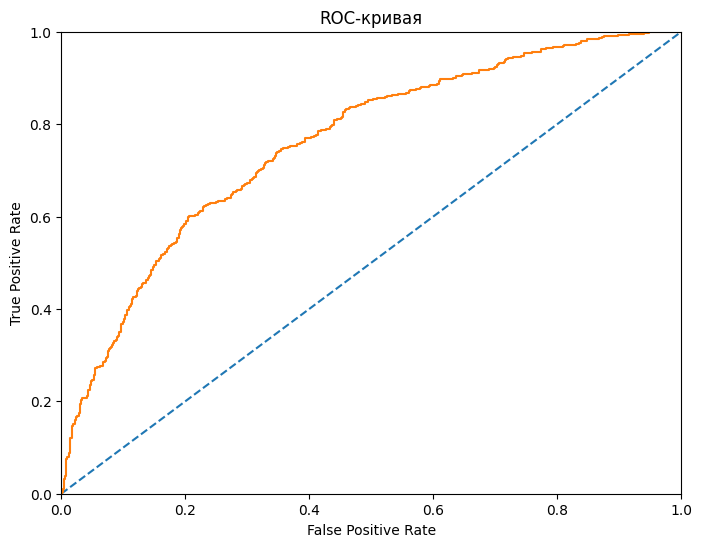

In [13]:
model_log_reg = LogisticRegression(random_state=12345, solver='liblinear')

model_log_reg.fit(features_train, target_train)

predict_train_log_reg = model_log_reg.predict(features_train)

predict_valid_log_reg = model_log_reg.predict(features_valid)
probabilities_one_valid_log_reg = model_log_reg.predict_proba(features_valid)[:, 1]

print('F1 score на тренировочной выборке {:.3f}'.format(f1_score(predict_train_log_reg, target_train)))
print('F1 score на валидационной выборке {:.3f}'.format(f1_score(predict_valid_log_reg, target_valid)))
print('AUC-ROC  на валидационной выборке {:.3f}'.format(roc_auc_score(target_valid, probabilities_one_valid_log_reg)))

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_log_reg)

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Метрика F1 довольно низкая, модель не очень хорошо разобралась в классе "1". При этом ROC-кривая показывает, что модель ведет себя лучше случайной.

##### 3.1.2. Решающее дерево<a name="disdecisiontree"></a>  
[к содержанию](#content)

Обучим модель решающего дерева и подберем для неё оптимальную глубину.

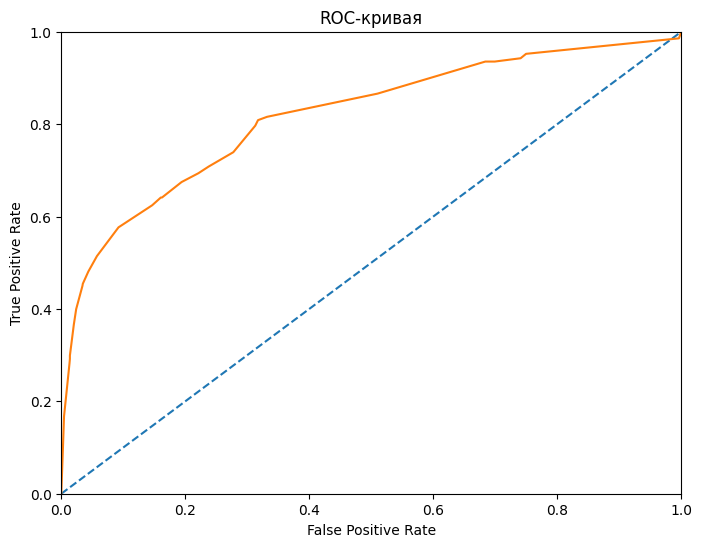

In [14]:
best_depth = None
best_f1 = 0


for depth in range(1, 16, 1):
    
    model_dec_tr = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dec_tr.fit(features_train, target_train)
    predict_valid_dec_tr = model_dec_tr.predict(features_valid)
    f1 = f1_score(predict_valid_dec_tr, target_valid)

    if f1 > best_f1:

        best_f1 = f1
        best_depth = depth


model_dec_tr = DecisionTreeClassifier(random_state=12345, max_depth=best_depth)
model_dec_tr.fit(features_train, target_train)

predict_train_dec_tr = model_dec_tr.predict(features_train)

predict_valid_dec_tr = model_dec_tr.predict(features_valid)
probabilities_one_valid_dec_tr = model_dec_tr.predict_proba(features_valid)[:, 1]

print('F1 score на тренировочной выборке {:.3f}'.format(f1_score(predict_train_dec_tr, target_train)))
print('F1 score на валидационной выборке {:.3f}'.format(f1_score(predict_valid_dec_tr, target_valid)))
print('AUC-ROC  на валидационной выборке {:.3f}'.format(roc_auc_score(target_valid, probabilities_one_valid_dec_tr)))
print('Оптимальная глубина решающего дерева = {}'.format(best_depth))

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_dec_tr)

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Заметно лучше логистической регрессии, переобучения удалось избежать.

##### 3.1.3. Случайный лес<a name="disrandomforest"></a>  
[к содержанию](#content)

Теперь самая точная и самая "медленная" модель - случайный лес. Подберем для неё оптимальные гиперпараметры.

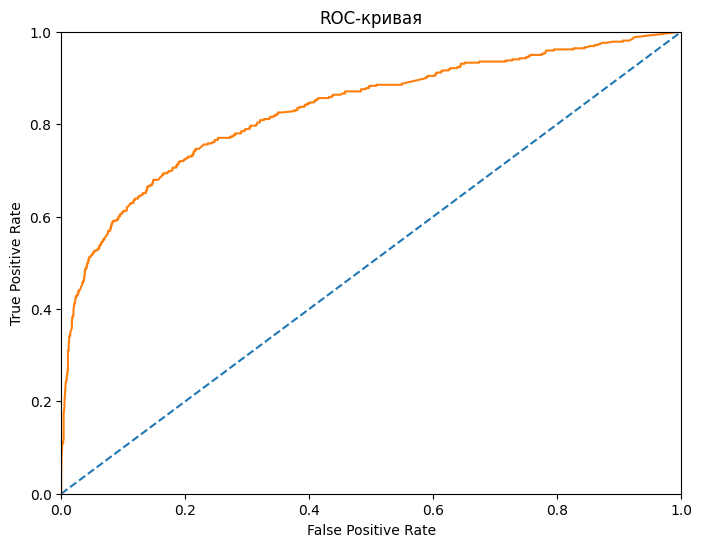

In [15]:
best_depth = None
best_f1 = 0
est = None


for est in range(10, 101, 5):

    for depth in range(1, 16, 1):

        model_ran_for = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
        model_ran_for.fit(features_train, target_train)
        predict_valid_ran_for = model_ran_for.predict(features_valid)
        f1 = f1_score(predict_valid_ran_for, target_valid)

        if f1 > best_f1:
            
            best_f1 = f1
            best_depth = depth
            best_est = est


model_ran_for = RandomForestClassifier(random_state=12345, max_depth=best_depth, n_estimators=best_est)
model_ran_for.fit(features_train, target_train)

predict_train_ran_for = model_ran_for.predict(features_train)

predict_valid_ran_for = model_ran_for.predict(features_valid)
probabilities_one_valid_ran_for = model_ran_for.predict_proba(features_valid)[:, 1]

print('F1 score на тренировочной выборке {:.3f}'.format(f1_score(predict_train_ran_for, target_train)))
print('F1 score на валидационной выборке {:.3f}'.format(f1_score(predict_valid_ran_for, target_valid)))
print('AUC-ROC  на валидационной выборке {:.3f}'.format(roc_auc_score(target_valid, probabilities_one_valid_ran_for)))
print('Оптимальная глубина деревьев = {}, оптимальное количество деревьев = {}'.format(best_depth, best_est))

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_ran_for)

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Результат не сильно превзошёл решающее дерево, при этом модель переобучилась, судя по F1 на тренировочной выборке.

Лучший результат показала модель решающего дерева.  
Логистическая регрессия недообучилась, случайный лес переобучился. При этом все три модели показывают результат лучше случайных.  
Мы попробуем сбалансировать классы, и обучить модели ещё раз, чтобы увеличить метрику F1.

#### 3.2. Балансирование классов<a name="balancingclasses"></a>  
[к содержанию](#content)

Сбалансируем классы методом *upsampling*, поскольку данных не очень много, а проведение *downsampling* приведет к потере 60% данных.  

Напишем функцию для этой цели.

In [16]:
def upsample(features, target, repeat):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

Увеличим размер тренировочной выборки с классом "1" в 4 раза, т.к. имеем соотношение 4:1.

In [17]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

Приступим к обучению моделей.

##### 3.2.1. Логистическая регрессия<a name="ballogisticregress"></a>  
[к содержанию](#content)

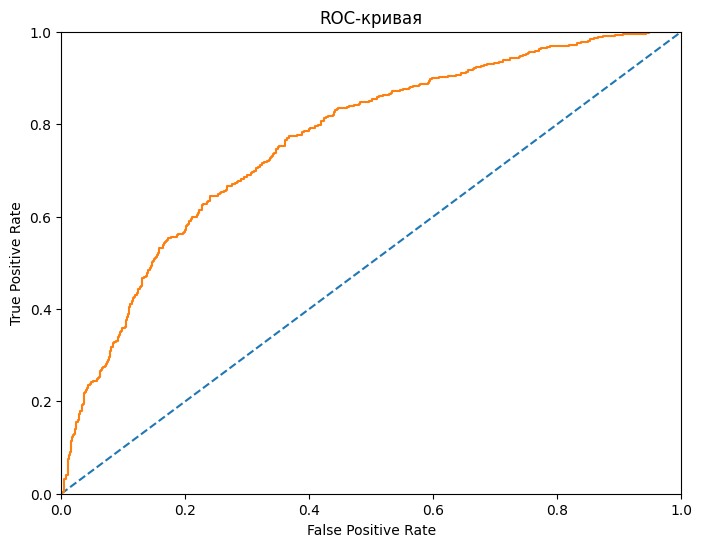

In [18]:
model_log_reg = LogisticRegression(random_state=12345, solver='liblinear')

model_log_reg.fit(features_upsampled, target_upsampled)

predict_train_log_reg = model_log_reg.predict(features_upsampled)

predict_valid_log_reg = model_log_reg.predict(features_valid)
probabilities_one_valid_log_reg = model_log_reg.predict_proba(features_valid)[:, 1]

print('F1 score на тренировочной выборке {:.3f}'.format(f1_score(predict_train_log_reg, target_upsampled)))
print('F1 score на валидационной выборке {:.3f}'.format(f1_score(predict_valid_log_reg, target_valid)))
print('AUC-ROC  на валидационной выборке {:.3f}'.format(roc_auc_score(target_valid, probabilities_one_valid_log_reg)))

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_log_reg)

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Уже лучше, но недостаточно.

##### 3.2.2. Решающее дерево<a name="baldecisiontree"></a>  
[к содержанию](#content)

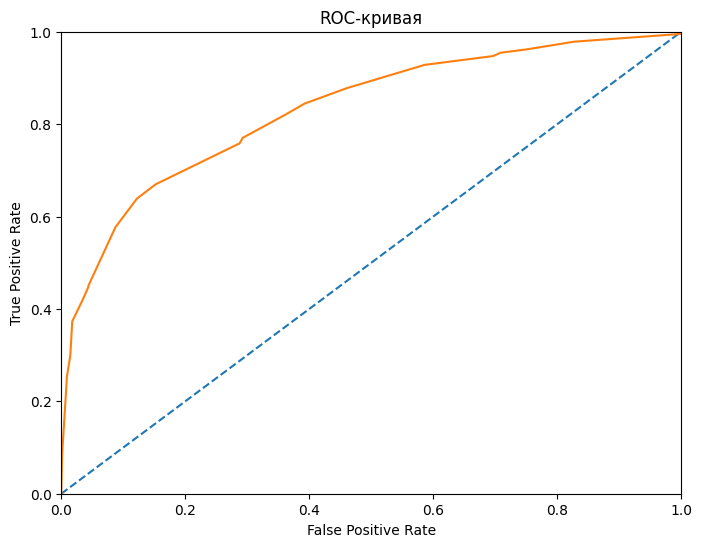

In [19]:
best_depth = None
best_f1 = 0


for depth in range(1, 16, 1):
    
    model_dec_tr = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dec_tr.fit(features_upsampled, target_upsampled)
    predict_valid_dec_tr = model_dec_tr.predict(features_valid)
    f1 = f1_score(predict_valid_dec_tr, target_valid)

    if f1 > best_f1:

        best_f1 = f1
        best_depth = depth


model_dec_tr = DecisionTreeClassifier(random_state=12345, max_depth=best_depth)
model_dec_tr.fit(features_upsampled, target_upsampled)

predict_train_dec_tr = model_dec_tr.predict(features_upsampled)

predict_valid_dec_tr = model_dec_tr.predict(features_valid)
probabilities_one_valid_dec_tr = model_dec_tr.predict_proba(features_valid)[:, 1]

print('F1 score на тренировочной выборке {:.3f}'.format(f1_score(predict_train_dec_tr, target_upsampled)))
print('F1 score на валидационной выборке {:.3f}'.format(f1_score(predict_valid_dec_tr, target_valid)))
print('AUC-ROC  на валидационной выборке {:.3f}'.format(roc_auc_score(target_valid, probabilities_one_valid_dec_tr)))
print('Оптимальная глубина решающего дерева = {}'.format(best_depth))

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_dec_tr)

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Результат ещё лучше, но проверим последнюю модель.

##### 3.2.3. Случайный лес<a name="balrandomforest"></a>  
[к содержанию](#content)

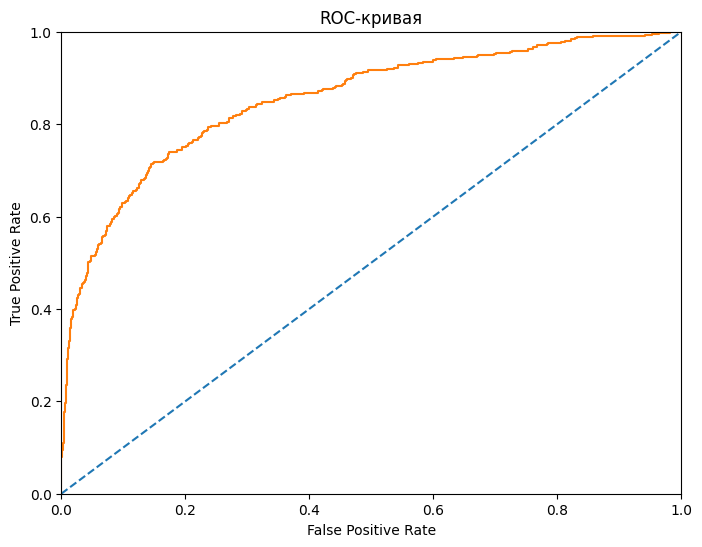

In [20]:
best_depth = None
best_f1 = 0
est = None


for est in range(10, 101, 5):

    for depth in range(1, 16, 1):

        model_ran_for = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
        model_ran_for.fit(features_upsampled, target_upsampled)
        predict_valid_ran_for = model_ran_for.predict(features_valid)
        f1 = f1_score(predict_valid_ran_for, target_valid)

        if f1 > best_f1:
            
            best_f1 = f1
            best_depth = depth
            best_est = est


model_ran_for = RandomForestClassifier(random_state=12345, max_depth=best_depth, n_estimators=best_est)
model_ran_for.fit(features_upsampled, target_upsampled)

predict_train_ran_for = model_ran_for.predict(features_upsampled)

predict_valid_ran_for = model_ran_for.predict(features_valid)
probabilities_one_valid_ran_for = model_ran_for.predict_proba(features_valid)[:, 1]

print('F1 score на тренировочной выборке {:.3f}'.format(f1_score(predict_train_ran_for, target_upsampled)))
print('F1 score на валидационной выборке {:.3f}'.format(f1_score(predict_valid_ran_for, target_valid)))
print('AUC-ROC  на валидационной выборке {:.3f}'.format(roc_auc_score(target_valid, probabilities_one_valid_ran_for)))
print('Оптимальная глубина деревьев = {}, оптимальное количество деревьев = {}'.format(best_depth, best_est))

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_ran_for)

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Отлично.  
Наилучший результат, как и предполагалось, показывает случайный лес. Проверим его на тестовой выборке.

### 4. Финальное тестирование<a name="finaltest"></a>  
[к содержанию](#content)

In [21]:
predict_test_ran_for = model_ran_for.predict(features_test)
probabilities_one_test_ran_for = model_ran_for.predict_proba(features_test)[:, 1]

print('F1 score на тестовой выборке {:.3f}'.format(f1_score(predict_test_ran_for, target_test)))
print('AUC-ROC  на тестовой выборке {:.3f}'.format(roc_auc_score(target_test, probabilities_one_test_ran_for)))

### 5. Выводы<a name="opinion"></a>  
[к содержанию](#content)

При сбалансированных классах результат получился лучше, но не намного. Думаю дело в том, что соотношение классов (4:1) оказалось достаточным, чтобы модель "уловила" нужные закономерности. Серьёзно улучшились показатели только у логистической регрессии.  

Лучший результат показала модель случайного леса с глубиной = 9, и количеством деревьев = 70. F1 на валидационной выборке 0.629, на тестовой 0.608.